# 1. Web scraping
## RedFin

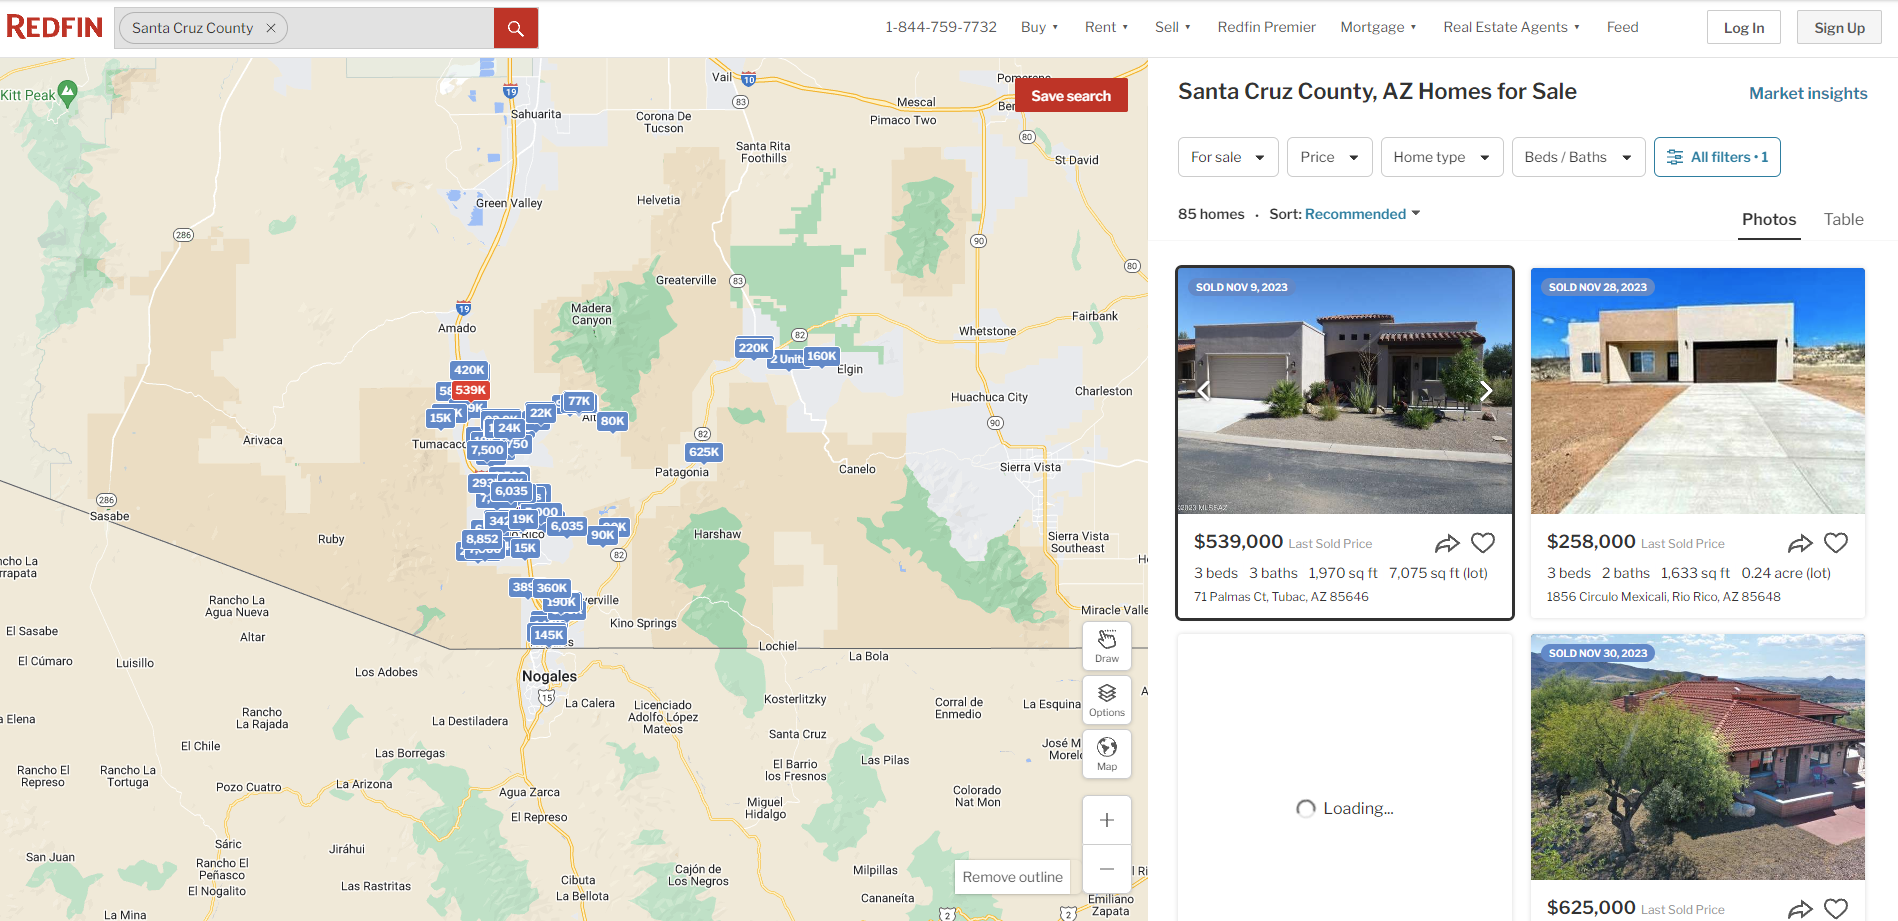

Website: https://www.redfin.com/county/225/AZ/Santa-Cruz-County/filter/property-type=land,min-lot-size=2-acre,max-lot-size=20-acre

# 2. Objective
Need to extract data from RedFin on a specific county in the USA. The county is Santa Cruz County, AZ.

## 2.1 Where I want to scrape?
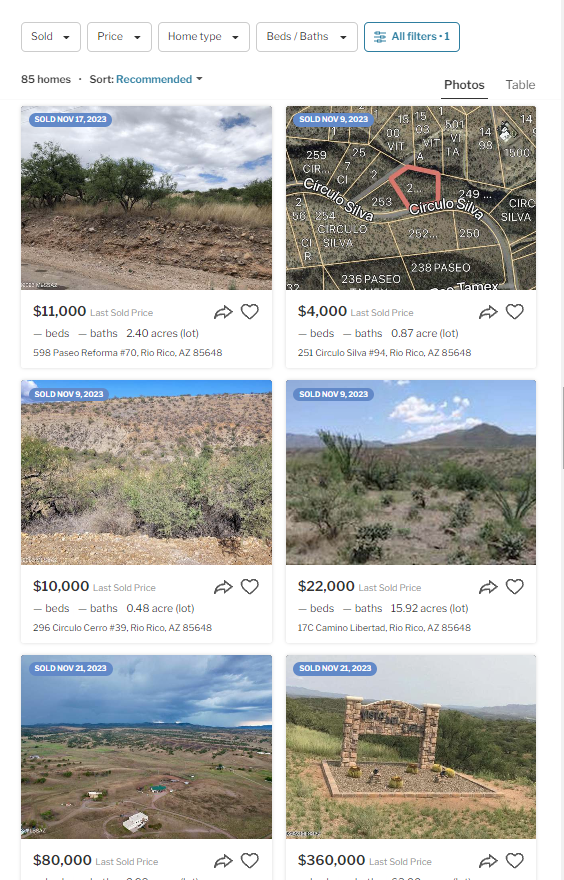


I want to scrape only these cards but not directly to individual card

# 3. Expected outcome
spreadsheet or .csv file

# 4. Start notebook!

## 4.1 Import Libraries

### Progress bar

In [1]:
# For display Progress bar
from tqdm import tqdm

### Data Manipulation

In [25]:
import numpy as np
import re
import pandas as pd
import time
from datetime import datetime
import json

### HTML content

In [ ]:
from bs4 import BeautifulSoup
import requests
# Selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

### Visualization

In [ ]:
from IPython.display import Image

## 4.2 Scraper

In [4]:
def redfin_scraper(county_information, filter, latitude_n=None, latitude_s=None, longitude_n=None, longitude_s=None):
    def _load_soup(driver, page=None, index=None):
        get_url = driver.current_url
        print(f'Loading content... {get_url}')
        start_loading_time = time.time()
        if page is not None:
            driver.get(f'{website_path}/page-{page}')

        driver, index = _find_element_scrolling(driver=driver, index=index)
        innerHTML = driver.execute_script('return document.body.innerHTML')
        time.sleep(1)
        loading_time = time.time() - start_loading_time
        print(f'Loaded! Time taken: {loading_time:.2f} seconds')
        soup = BeautifulSoup(innerHTML, "html.parser")
        return soup, driver, index

    def extract_numerical(string, as_integer=False):
        if string is None:
            return None
        
        matches = re.findall(r'[-+]?\d*\.?\d+(?:,\d{3})*(?=\s|\b|$)', string)
        numerical_value = matches[0].replace(',', '') if matches else None

        if numerical_value is not None:
            if as_integer:
                return int(float(numerical_value))
            else:
                return float(numerical_value)

        return None

    def _find_element_scrolling(driver, index=None):
        wait_time, max_index = 0.2, 40
        wait = WebDriverWait(driver, 5)
        index = index if index else 0
        while True:
            try:
                element = wait.until(EC.visibility_of_all_elements_located((By.XPATH, f'//*[@id="MapHomeCard_{index}"]')))
                driver.execute_script("arguments[0].scrollIntoView();", element[-1])
                time.sleep(wait_time)
                index += 1
                if index % max_index == 0:
                    break
            except Exception as e:
                print(f"An error occurred: {e}")
                break
        return driver, index

    def _get_json_content(script_tag):
        try:
            json_content = json.loads(script_tag.contents[0])
            return json_content
        except (KeyError, json.JSONDecodeError, IndexError):
            pass
        return None
    def _extract_offer_info(json_content):
        if isinstance(json_content, list):
            offers = json_content[1].get('offers', {})
            return offers.get('price'), offers.get('priceCurrency')
        elif isinstance(json_content, dict):
            offers = json_content.get('offers', {})
            return offers.get('price'), offers.get('priceCurrency')
        return None, None

    def _extract_address_fields(json_content):
        address_fields = ['streetAddress', 'addressLocality', 'addressRegion', 'postalCode', 'addressCountry']
        if isinstance(json_content, list) and len(json_content) >= 2:
            for item in json_content:
                if item.get('address'):
                    return [item['address'].get(field) for field in address_fields]
        elif isinstance(json_content, dict) and json_content.get('address'):
            return [json_content['address'].get(field) for field in address_fields]
        return [None] * 5

    def _extract_home_stats(home_stat):
        pattern_1 = r"(\d+\.\d+) (\w+ \(lot\))"
        pattern_2 = r"(\d{1,3}(?:,\d{3})*) sq ft"
        pattern_3 = r"\d+(\.\d+)? bed(s)?"
        pattern_4 = r"\d+(\.\d+)? bath(s)?"
        if home_stat:
            text = home_stat.text
            reg_size = re.search(pattern_1, text)
            reg_size_sqft = re.search(pattern_2, text)
            reg_bed = re.search(pattern_3, text)
            reg_bath = re.search(pattern_4, text)
    
            size = extract_numerical(string=reg_size.group(0) if reg_size else None, as_integer=True)
            size_unit = reg_size.group(2) if reg_size else None
            size_sqft = extract_numerical(string=reg_size_sqft.group(1) if reg_size_sqft else None,as_integer=False)
            bed = extract_numerical(string=reg_bed.group(0) if reg_bed else None, as_integer=True)
            bath = extract_numerical(string=reg_bath.group(0) if reg_bath else None,as_integer=True)
        return size_unit, bed, bath, size, size_sqft
    
    def _extract_and_convert_datetime(date_string):
        try:
            components = date_string.split(' ')[1:]
            # Remove any unexpected characters (e.g., '3D', 'WALKTHROUGH')
            components = [comp for comp in components if comp.isalpha()]
            if len(components) >= 3:
                month, day, year = components[:3]
                print(f'Date string components: month={month}, day={day}, year={year}')
                # Convert to datetime
                datetime_obj = datetime.strptime(f'{month} {day} {year}', '%b %d %Y')
                return datetime_obj
        except Exception as e:
            print(f"An error occurred during date conversion: {e}")
        return None
    def _extract_type(json_content):
        if isinstance(json_content, list):
            type1 = json_content[0].get('@type', {})
            type2 = json_content[1].get('@type', {})

            return type1, type2
        elif isinstance(json_content, dict):
            type1 = json_content.get('@type', {})
            return type1, None
        
    def _extract_number_of_rooms(json_content):
        if isinstance(json_content, list):
            num_of_room = json_content[0].get('numberOfRooms', {})
            return num_of_room
        elif isinstance(json_content, dict):
            num_of_room = json_content.get('numberOfRooms', {})
            return num_of_room

    base_url = "www.redfin.com"
    scraped_homes = []
    viewport = f'viewport={latitude_n}:{latitude_s}:{longitude_n}:{longitude_s}'
    website_path = None

    if filter.lower() == 'for sale':
        website_path = f"https://{base_url}/{county_information}"
        if latitude_n and latitude_s and longitude_n and longitude_s:
            website_path = f"https://{base_url}/{county_information}/filter/{viewport}"
    elif filter.lower() == 'for rent':
        website_path = f"https://{base_url}/{county_information}/apartments-for-rent"
        if latitude_n and latitude_s and longitude_n and longitude_s:
            website_path = f"https://{base_url}/{county_information}/apartments-for-rent/filter/{viewport}"
    elif re.match('sold-(1wk|1mo|3mo|6mo|1yr|2yr|3yr|5yr)', filter.lower()):
        print(f'Filter: {filter}')
        website_path = f"https://{base_url}/{county_information}/filter/include={filter}"
        if latitude_n and latitude_s and longitude_n and longitude_s:
            website_path = f"https://{base_url}/{county_information}/filter/include={filter},{viewport}"

    driver = webdriver.Chrome()
    driver.get(website_path)
    soup, driver, index = _load_soup(driver)
    n_home = int(soup.find('div', {'class': 'homes summary'}).text.split()[0].replace(',', ''))
    homecards = soup.find_all('div', {'data-rf-test-name': 'mapHomeCard'})
    len_home = len(homecards)
    n_page = int(np.ceil(n_home / len_home))  
    print('-'*30)
    print(f'Total page: {n_page}\nTotal home: {n_home}')
    print('-'*30)
    start_scraping_time = time.time()
    for page in tqdm(range(1, n_page + 1), desc='scraping...', total=n_page):
        print(f'Page: {page}')
        if page != 1:
            soup, driver, index = _load_soup(driver, page, index)
            homecards = soup.find_all('div', {'data-rf-test-name': 'mapHomeCard'})
            n_home = int(soup.find('div', {'class': 'homes summary'}).text.split()[0].replace(',', ''))
            homecards = soup.find_all('div', {'data-rf-test-name': 'mapHomeCard'})
            len_home = len(homecards)

        for home in homecards:
            href = home.find('a').get('href')
            home_url = f'https://{base_url}{href}'
            homecardV2, bottomV2 = home.find('div', {'class': 'homecardv2'}), home.find('div', {'class': 'bottomV2'})
            
            sold_datetime = homecardV2.find('div', {'class': 'topleft'}).text if homecardV2.find('div', {'class': 'topleft'}) else None
            if sold_datetime:
                home_sold_date = _extract_and_convert_datetime(sold_datetime)
            else:
                home_sold_date = None
            
            home_img, home_title = homecardV2.find('img').get('src') if homecardV2.find('img') else None, bottomV2.find('a').get('title') if bottomV2.find('a') else None
            home_price = bottomV2.find('span', {'class': 'homecardV2Price'}).text if bottomV2.find('span', {'class': 'homecardV2Price'}) else None
            if home_price:
                home_price = extract_numerical(string=home_price, as_integer=False)
            else:
                home_price = None
            # Json
            script_tag = bottomV2.find('script', {'type': 'application/ld+json'})
            json_content = _get_json_content(script_tag)
            address_street, address_locality, address_region, address_postal, address_country = _extract_address_fields(json_content)
            type1, type2 = _extract_type(json_content)
            number_of_rooms = _extract_number_of_rooms(json_content)
            price_usd, price_currency = _extract_offer_info(json_content)
            # Home Status
            home_stat = home.find('div', {'class': 'HomeStatsV2 font-size-small'})
            size_unit, home_bed, home_bath, home_size, home_sqft = _extract_home_stats(home_stat)

            result_dict = {
                'image': home_img,
                'title': home_title,
                'sold_date':home_sold_date,
                'json': json_content,
                'address_street': address_street,
                'address_locality': address_locality,
                'address_region': address_region,
                'address_postal': address_postal,
                'address_country': address_country,
                'type1': type1,
                'type2': type2,
                'number_of_rooms': number_of_rooms,
                'price': home_price,
                'price_usd': price_usd,
                'price_currency': price_currency,
                'url': home_url,
                'size': home_size,
                'size_unit': size_unit,
                'size_sqft': home_sqft,
                'bed': home_bed,
                'bath': home_bath,
                'remark': home.text,
            }

            scraped_homes.append(result_dict)

    scraping_time = time.time() - start_scraping_time
    print(f'Scraping completed! Time taken: {scraping_time:.2f} seconds ({scraping_time / 3600:.2f} hours)')

    driver.quit()
    return pd.DataFrame(scraped_homes)

## 4.3 Example Usage
filter including, 
- For sale: 'For sale'
- For rent: 'For rent'
- 'Sold': 'sold-3mo'
    - ['sold-1wk','sold-1mo','sold-3mo','sold-6mo','sold-1yr','sold-2yr','sold-3yr','sold-5yr']

In [5]:
# Example Usage

county_information = "county/225/AZ/Santa-Cruz-County"
filter = "For sale"
latitude_n = 31.74205
latitude_s = 31.29132
longitude_n = -110.51157
longitude_s = -111.30327

In [6]:
scraped_data = redfin_scraper(county_information, 
                                   filter, 
                                   latitude_n, 
                                   latitude_s, 
                                   longitude_n, 
                                   longitude_s)

Loading content...
Loaded! Time taken: 10.28 seconds
------------------------------
Total page: 17
Total home: 657
------------------------------


scraping...:   0%|          | 0/17 [00:00<?, ?it/s]

Page: 1
Page: 2
Loading content...


scraping...:  12%|█▏        | 2/17 [00:21<02:38, 10.57s/it]

Loaded! Time taken: 20.93 seconds
Page: 3
Loading content...


scraping...:  18%|█▊        | 3/17 [00:38<03:07, 13.37s/it]

Loaded! Time taken: 17.10 seconds
Page: 4
Loading content...
Loaded! Time taken: 37.48 seconds


scraping...:  24%|██▎       | 4/17 [01:16<04:51, 22.44s/it]

Page: 5
Loading content...


scraping...:  29%|██▉       | 5/17 [01:33<04:10, 20.84s/it]

Loaded! Time taken: 17.67 seconds
Page: 6
Loading content...


scraping...:  35%|███▌      | 6/17 [01:52<03:41, 20.14s/it]

Loaded! Time taken: 18.57 seconds
Page: 7
Loading content...
Loaded! Time taken: 81.42 seconds


scraping...:  41%|████      | 7/17 [03:14<06:39, 39.93s/it]

Page: 8
Loading content...


scraping...:  47%|████▋     | 8/17 [03:34<05:03, 33.72s/it]

Loaded! Time taken: 20.01 seconds
Page: 9
Loading content...
An error occurred: Message: 



scraping...:  53%|█████▎    | 9/17 [03:54<03:56, 29.57s/it]

Loaded! Time taken: 20.23 seconds
Page: 10
Loading content...
An error occurred: Message: 



scraping...:  59%|█████▉    | 10/17 [04:28<03:34, 30.69s/it]

Loaded! Time taken: 33.09 seconds
Page: 11
Loading content...
An error occurred: Message: 

Loaded! Time taken: 14.50 seconds


scraping...:  65%|██████▍   | 11/17 [04:42<02:35, 25.84s/it]

Page: 12
Loading content...
An error occurred: Message: 



scraping...:  71%|███████   | 12/17 [04:52<01:44, 20.93s/it]

Loaded! Time taken: 9.53 seconds
Page: 13
Loading content...
An error occurred: Message: 



scraping...:  76%|███████▋  | 13/17 [05:05<01:14, 18.62s/it]

Loaded! Time taken: 13.15 seconds
Page: 14
Loading content...
An error occurred: Message: 



scraping...:  82%|████████▏ | 14/17 [05:17<00:49, 16.61s/it]

Loaded! Time taken: 11.84 seconds
Page: 15
Loading content...
An error occurred: Message: 



scraping...:  88%|████████▊ | 15/17 [05:29<00:30, 15.13s/it]

Loaded! Time taken: 11.58 seconds
Page: 16
Loading content...
An error occurred: Message: 

Loaded! Time taken: 10.14 seconds


scraping...:  94%|█████████▍| 16/17 [05:39<00:13, 13.70s/it]

Page: 17
Loading content...
An error occurred: Message: 



scraping...: 100%|██████████| 17/17 [05:51<00:00, 20.66s/it]

Loaded! Time taken: 11.10 seconds
Date string components: month=SALE, day=BY, year=OWNER
An error occurred during date conversion: time data 'SALE BY OWNER' does not match format '%b %d %Y'
Date string components: month=SALE, day=BY, year=OWNER
An error occurred during date conversion: time data 'SALE BY OWNER' does not match format '%b %d %Y'
Scraping completed! Time taken: 351.16 seconds (0.10 hours)


In [7]:
scraped_data

,image,title,sold_date,json,address_street,address_locality,address_region,address_postal,address_country,type1,...,price,price_usd,price_currency,url,size,size_unit,size_sqft,bed,bath,remark
0,https://ssl.cdn-redfin.com/photo/86/islphoto/2...,"458 Chalet Ct, Rio Rico, AZ 85648",None,"[{'@context': 'http://schema.org', 'name': '45...",458 Chalet Ct,Rio Rico,AZ,85648,US,SingleFamilyResidence,...,"$285,000",285000,USD,https://www.redfin.com/AZ/Rio-Rico/458-Chalet-...,0.0,acre (lot),1680.0,4.0,3.0,"Santa Cruz County, AZ Home for SalePride of ow..."
1,https://ssl.cdn-redfin.com/photo/86/islphoto/6...,"131-2 Amado Montosa Rd, Amado, AZ 85645",None,"[{'@context': 'http://schema.org', 'name': '13...",131-2 Amado Montosa Rd,Amado,AZ,85645,US,SingleFamilyResidence,...,"$6,500,000",6500000,USD,https://www.redfin.com/AZ/Amado/131-Amado-Mont...,632.0,acres (lot),5400.0,6.0,8.0,"Santa Cruz County, AZ Home for SaleThe 3,792 a..."
2,https://ssl.cdn-redfin.com/photo/86/islphoto/6...,"1829 Camino Lebanon --, Rio Rico, AZ 85648",None,"[{'@context': 'http://schema.org', 'name': '18...",1829 Camino Lebanon --,Rio Rico,AZ,85648,US,SingleFamilyResidence,...,"$244,900",244900,USD,https://www.redfin.com/AZ/Rio-Rico/1829-Lebano...,0.0,acre (lot),1322.0,3.0,2.0,"Santa Cruz County, AZ Home for SaleEmbrace the..."
3,https://ssl.cdn-redfin.com/photo/86/islphoto/9...,"257 E Camino Vista Del Cielo --, Nogales, AZ 8...",None,"[{'@context': 'http://schema.org', 'name': '25...",257 E Camino Vista Del Cielo --,Nogales,AZ,85621,US,SingleFamilyResidence,...,"$355,000",355000,USD,https://www.redfin.com/AZ/Nogales/257-E-Camino...,2.0,acres (lot),2450.0,3.0,3.0,"Santa Cruz County, AZ Home for SaleExceptional..."
4,https://ssl.cdn-redfin.com/photo/86/islphoto/7...,"46 Circulo Verdugo --, Rio Rico, AZ 85648",None,"[{'@context': 'http://schema.org', 'name': '46...",46 Circulo Verdugo --,Rio Rico,AZ,85648,US,SingleFamilyResidence,...,"$325,000",325000,USD,https://www.redfin.com/AZ/Rio-Rico/46-Circulo-...,0.0,acre (lot),1553.0,3.0,2.0,"Santa Cruz County, AZ Home for SaleExcellent a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,None,"1810 Cajeme Ct, Rio Rico, AZ 85648",None,"[{'@context': 'http://schema.org', 'name': '18...",1810 Cajeme Ct,Rio Rico,AZ,85648,US,SingleFamilyResidence,...,"$249,000",249000,USD,https://www.redfin.com/AZ/Rio-Rico/1810-Cajeme...,0.0,acre (lot),1343.0,3.0,2.0,"Santa Cruz County, AZ Home for SaleFantastic o..."
516,None,"1795 Benecia Ct, Rio Rico, AZ 85648",None,"[{'@context': 'http://schema.org', 'name': '17...",1795 Benecia Ct,Rio Rico,AZ,85648,US,SingleFamilyResidence,...,"$234,999",234999,USD,https://www.redfin.com/AZ/Rio-Rico/1795-Beneci...,0.0,acre (lot),1350.0,3.0,2.0,"Santa Cruz County, AZ Home for SaleThis is you..."
517,None,"3 Alegria Rd, Tubac, AZ 85646",None,"[{'@context': 'http://schema.org', 'name': '3 ...",3 Alegria Rd,Tubac,AZ,85646,US,SingleFamilyResidence,...,"$762,000",762000,USD,https://www.redfin.com/AZ/Tubac/3-Alegria-Rd-8...,1.0,acres (lot),2977.0,2.0,3.0,"Santa Cruz County, AZ Home for SaleWith views ..."
518,None,"411 Post Way, Tubac, AZ 85646",None,"[{'@context': 'http://schema.org', 'name': '41...",411 Post Way,Tubac,AZ,85646,US,SingleFamilyResidence,...,"$296,000",296000,USD,https://www.redfin.com/AZ/Tubac/411-Post-Way-8...,NaN,None,1008.0,1.0,2.0,"Santa Cruz County, AZ Home for SaleEnjoy this ..."


In [24]:
scraped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             347 non-null    object 
 1   title             520 non-null    object 
 2   sold_date         0 non-null      object 
 3   json              520 non-null    object 
 4   address_street    520 non-null    object 
 5   address_locality  520 non-null    object 
 6   address_region    520 non-null    object 
 7   address_postal    520 non-null    object 
 8   address_country   520 non-null    object 
 9   type1             520 non-null    object 
 10  type2             520 non-null    object 
 11  number_of_rooms   202 non-null    object 
 12  price             520 non-null    object 
 13  price_usd         520 non-null    object 
 14  price_currency    520 non-null    object 
 15  url               520 non-null    object 
 16  size              453 non-null    float64
 1

## Check Missing value

In [8]:
def check_missing_values(df):
    count = df.isnull().sum()
    percentage = (df.isnull().mean()) * 100

    summary = pd.DataFrame({
        'Missing Values': count,
        'Percentage Missing': percentage
    })
    summary = summary.sort_values(by='Missing Values', ascending=False).style.background_gradient(cmap='Oranges')
    return summary

In [9]:
check_missing_values(df=scraped_data)

,Missing Values,Percentage Missing
sold_date,520,100.000000
number_of_rooms,318,61.153846
bed,318,61.153846
bath,317,60.961538
size_sqft,315,60.576923
image,173,33.269231
size,67,12.884615
size_unit,67,12.884615
address_region,0,0.000000
address_postal,0,0.000000


## Check Image data

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

In [20]:
def plot_images(images, title, num_display=16, num_cols=4, random_mode=False):
    """
    Plot multiple images in a grid.

    Parameters:
    - images: List of image paths or URLs. May contain None values.
    - title: Title for the plot.
    - num_display: Number of images to display (default is 16).
    - num_cols: Number of columns in the grid (default is 4).
    - random_mode: If True, randomly select images to display (default is False).
    """
    if random_mode:
        images = images.sample(frac=1)  # Shuffle the DataFrame if using pandas DataFrame

    num_rows = int(np.ceil(num_display / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12))

    for i in range(num_display):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if i < len(images) and images.iloc[i] is not None:
            if isinstance(images.iloc[i], str) and images.iloc[i]:
                # If the element is a URL, open it with Pillow
                response = requests.get(images.iloc[i])
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
            else:
                # If the element is an array, use it directly
                ax.imshow(images.iloc[i])

    fig.suptitle(title, fontsize=16)
    plt.show()


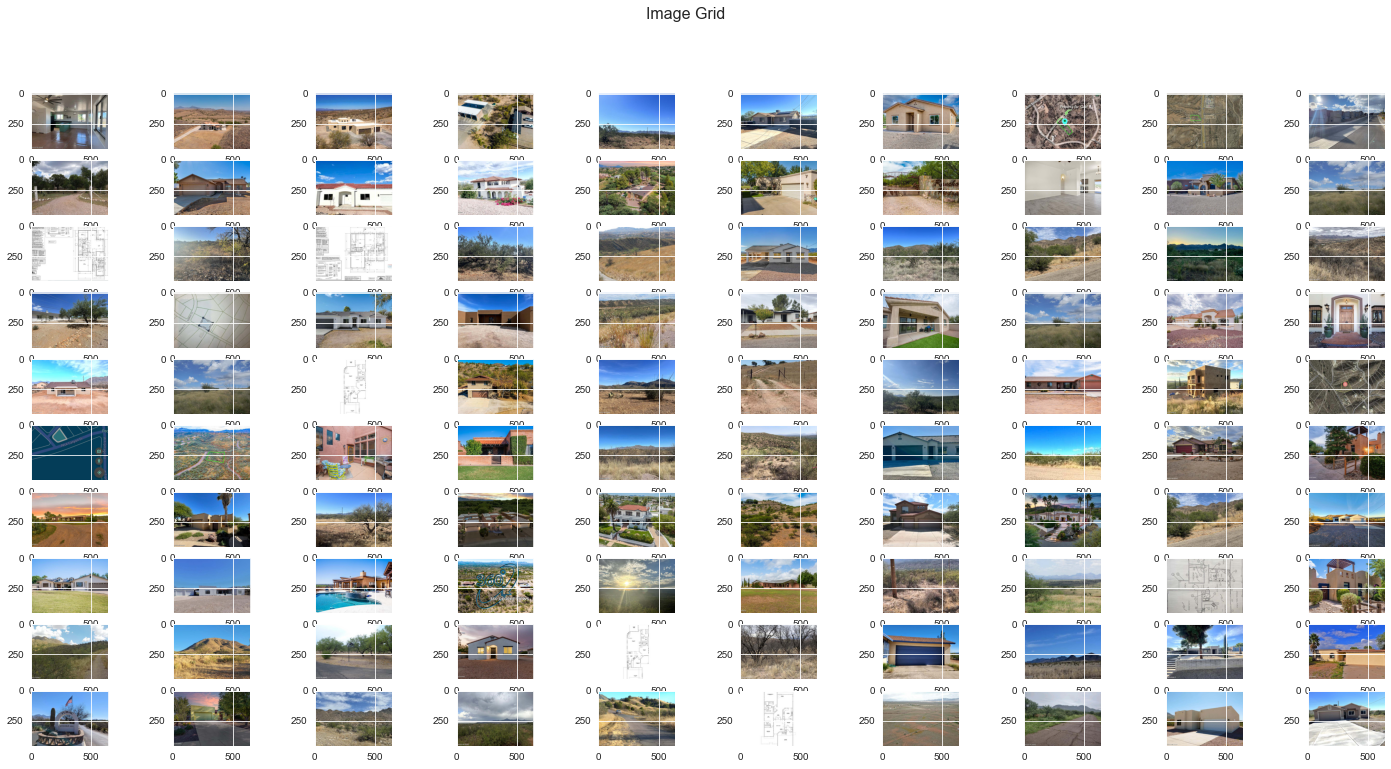

In [23]:
plot_images(scraped_data.loc[scraped_data['image'].notna()]['image'], 
            title="Image Grid", 
            num_display=100, 
            num_cols=10, 
            random_mode=True)

# Export
outcome: .csv file

In [13]:
scraped_data.to_csv('scraped_data.csv', index=False)